In [54]:
import torch
import numpy as np 
import os
import sys
import numba as nb
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time
from sklearn.datasets import make_swiss_roll, make_moons, make_circles
import ot

os.chdir('/home/baly/projects/linear_opt')

#from lib.library import *
from lib.lib_ot import *
from lib.lib_lopt import *
#from lib.lib_shape import *


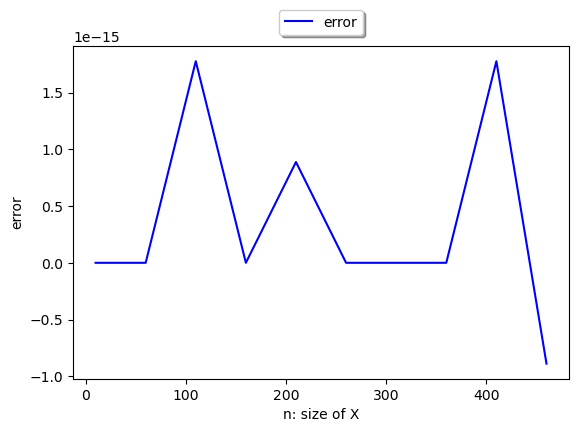

In [58]:
# test correctness
Lambda=5.0
step_size=50
k=1
n_list=np.array(range(10,500,step_size))
opt_cost1=np.zeros((n_list.shape[0],k))
opt_cost2=np.zeros((n_list.shape[0],k))

for i in range(n_list.shape[0]):
    n=n_list[i]
    for k_p in range(k):
        X0=np.random.uniform(-20,20,(n,2))+15
        X1=np.random.uniform(-20,20,(n,2))+0
        X2=np.random.uniform(-20,20,(n,2))+30

        p0=np.ones(n)/n
        p1=np.ones(n)/n
        p2=np.ones(n)/n
        cost1,gamma,penualty1=opt_lp(X0,X1,p0,p1,Lambda,numItermax=200000)
        opt_cost1[i,k_p]=cost1+penualty1
        U0=np.zeros((n,2))
        M0=0.0
        p0_hat=p0
        U1,p1_hat,M1=lopt_embedding(X0,X1,p0,p1,Lambda)
        cost2,penualty2=lopt(U1,U0,p1_hat,p0_hat,Lambda,M1,M0)
#        cost2=np.sum((U1.T)**2*p1_hat)
#        penualty2=Lambda*(np.sum(np.abs(p0-p1_hat))+M1)
        
        opt_cost2[i,k_p]=cost2+penualty2

#        Vi,p0_Ti=linear_embedding(Xi,X0,p1,p0,Lambda)
#        Vj,p0_Tj=linear_embedding(Xj,X0,p2,p0,Lambda)
#        Vij,p0_Tij=vector_plus(Vi,-Vj,p0_Ti,p0_Tj)
#        cost2,penualty2=vector_norm(Vij,p0_Tij,1,Lambda)
#        opt_cost2[i,k_p]=cost2+penualty2
        # if cost2+penualty2<cost1+penualty1-0.00001:
            #     print('error')
            #     print('cost2',cost2)
    #     print('cost1',cost1)
    #     print('penualty1',penualty1)
    #     print('penualty2',penualty2)
    #     break



fig = plt.figure()
ax = plt.subplot(111)
error=opt_cost2-opt_cost1
error_mean=error.mean(1)
error_std=error.std(1)

plt.plot(n_list,error_mean,'-',c='blue',label='error')
plt.fill_between(n_list,error_mean-1*error_std,error_mean+1*error_std,alpha=0.3)

plt.xlabel("n: size of X")
plt.ylabel("error")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.13),
          fancybox=True, shadow=True, ncol=3)
#plt.savefig('experiment/test/results/accuracy_error'+str(Lambda)+'.png',format="png",dpi=800,bbox_inches='tight')
plt.show()


In [ ]:
Lambda=20.0
step_size=50

l=5
K_list=[2,4]
n_list=np.array(range(200,1050,step_size))

m_list=np.array([[1.,1.],[-1.,-1.],[-1.,1.],[1.,-1.]])

id2=np.eye(2)
Lambda_list=[10.0,5.0,1.0]
save_dict={}

for K in K_list:
    List_ij=[]
    for i in range(K):
        for j in range(i+1,K):
            List_ij.append((i,j))
    n_compute=len(List_ij)

    for Lambda in Lambda_list:
        print('Lambda',Lambda)
        opt_cost1=np.zeros((n_list.shape[0],l,n_compute))
        opt_cost2=np.zeros((n_list.shape[0],l,n_compute))
        opt_cost3=np.zeros((n_list.shape[0],l,n_compute))
        #save_dict['Lambda'+str(Lambda)]={}
        for epoch,n in enumerate(n_list):
            print('n',n)
            for l_p in range(l):
                #generate data
                X_list=list()
                p_list=list()
                for i in range(K):
                    vi=m_list[i]
                    Xi=np.random.multivariate_normal(vi,id2,n)
                    X_list.append(Xi)    
                    p_list.append(np.ones(n))
                X_list=np.stack(X_list)
                p_list=np.stack(p_list)
                m_bar=np.mean(m_list,0)
                p0=np.ones(n)

                # compute OPT distance pairwisely 
                for k in range(n_compute):
                    i,j=List_ij[k]
                    X1=X_list[i]
                    X2=X_list[j]
                    p1=p_list[i]
                    p2=p_list[j]          
                    cost1,plan1,penualty1=opt_lp(X1,X2,p1,p2,Lambda,numItermax=1000*n)
                    opt_cost1[epoch,l_p,k]=cost1+penualty1

                # compute lopt embedding
                X01=np.random.multivariate_normal(m_bar,id2,n)
                opt_embedding_list1=[]

                for i in range(K):
                    Xi=X_list[i]
                    pi=p_list[i]
                    Ui,pi_hat,Mi=lopt_embedding(X01,Xi,p0,pi,Lambda,numItermax=1000*n)
                    opt_embedding_list1.append((Ui,pi_hat,Mi))
                for k in range(n_compute):
                    i,j=List_ij[k]
                    Ui,pi_hat,Mi=opt_embedding_list1[i]
                    Uj,pj_hat,Mj=opt_embedding_list1[j]
                    cost2,penualty2=lopt(Ui,Uj,pi_hat,pj_hat,Lambda,Mi,Mj)
                    opt_cost2[epoch,l_p,k]=cost2+penualty2

                # compute the lopt embedding by barycenter 
                X_init=X01
                weights=np.ones(K)/K
                X02=X01.copy()
                X02=lot_barycenter(X_list, p_list, X_init, p0, weights, numItermax=50,numItermax_LP=1000*n,stopThr=1e-4)
                opt_embedding_list2=list()
                for i in range(K):
                    Xi=X_list[i]
                    pi=p_list[i]
                    Ui,pi_hat,Mi=lopt_embedding(X02,Xi,p0,pi,Lambda,numItermax=1000*n)
                    opt_embedding_list2.append((Ui,pi_hat,Mi))
                for k in range(n_compute):
                    i,j=List_ij[k]
                    Ui,pi_hat,Mi=opt_embedding_list2[i]
                    Uj,pj_hat,Mj=opt_embedding_list2[j]
                    cost3,penualty3=lopt(Ui,Uj,pi_hat,pj_hat,Lambda,Mi,Mj)
                    opt_cost3[epoch,l_p,k]=cost3+penualty3
        save_dict['Lambda=%d,K=%d,opt_cost1'%(Lambda,K)]=opt_cost1
        save_dict['Lambda=%d,K=%d,opt_cost2'%(Lambda,K)]=opt_cost2
        save_dict['Lambda=%d,K=%d,opt_cost3'%(Lambda,K)]=opt_cost3
torch.save(save_dict,'experiment/performance/cost_list.pt')

Lambda 10.0
n 200
n 250
n 300
n 350
n 400
n 450
n 500
n 550
n 600
n 650
n 700
n 750
n 800
n 850
n 900
n 950
n 1000
Lambda 5.0
n 200
n 250
n 300
n 350
n 400
n 450
n 500
n 550
n 600
n 650
n 700
n 750
n 800
n 850
n 900
n 950
n 1000
Lambda 1.0
n 200
n 250
n 300
n 350
n 400
n 450
n 500
n 550
n 600
n 650
n 700
n 750
n 800
n 850
n 900
n 950
n 1000
Lambda 10.0
n 200
n 250
n 300
n 350
n 400
n 450
n 500
n 550
n 600
n 650
n 700
n 750
n 800
n 850
n 900
n 950
n 1000
Lambda 5.0
n 200
n 250
n 300
n 350
n 400
n 450
n 500
n 550
n 600
n 650
n 700
n 750
n 800
n 850
n 900
n 950
n 1000
Lambda 1.0
n 200
n 250
n 300
n 350
n 400
n 450
n 500
n 550
n 600
n 650
n 700
n 750
n 800
n 850
n 900
n 950
n 1000


K, 2
Lambda, 10.0
Lambda, 5.0
Lambda, 1.0
K, 4
Lambda, 10.0
Lambda, 5.0
Lambda, 1.0


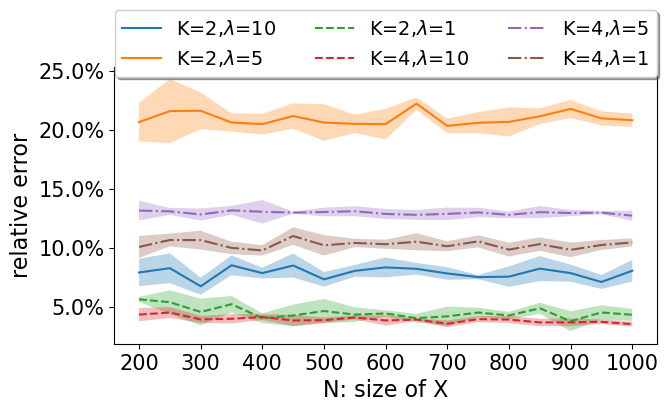

done
K, 2
Lambda, 10.0
Lambda, 5.0
Lambda, 1.0
K, 4
Lambda, 10.0
Lambda, 5.0
Lambda, 1.0


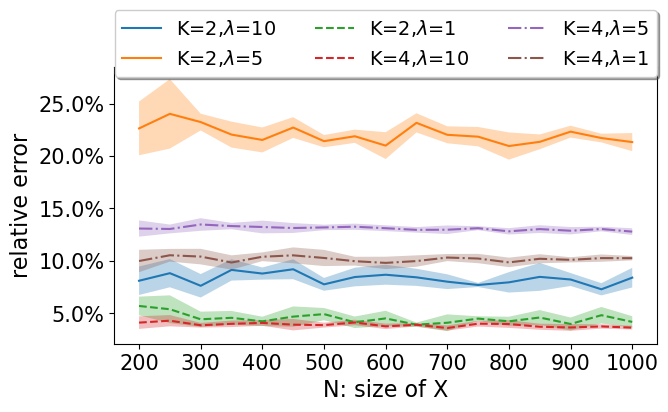

done


In [53]:
#save_dict=torch.load('experiment/performance/cost_list_K'+str(K)+ '.pt')
linestyle_array = ['-', '-', '--', '--', '-.', '-.']
#ax = plt.subplot(111)
save_dict2=torch.load('experiment/performance/cost_list.pt')
for x in [2,3]:
    fig = plt.figure(1, (7,4))
    ax = fig.add_subplot(1,1,1)
    ind=0
    for K in [2,4]:
        print('K,',K)
        for Lambda in Lambda_list:
            print('Lambda,',Lambda)
            opt_cost1=save_dict2['Lambda=%d,K=%d,opt_cost1'%(Lambda,K)]
            opt_cost2=save_dict2['Lambda=%d,K=%d,opt_cost%d'%(Lambda,K,x)]
            relative_error=(np.abs(opt_cost2-opt_cost1)/opt_cost1).mean(2)
            relative_error_mean=relative_error.mean(1)
            relative_error_std=relative_error.std(1)

            #label=r'K=%d,$\lambda$=%d'%(K,Lambda)
            ax.plot(n_list,relative_error_mean,linestyle_array[ind],label=r'K=%d,$\lambda$=%d'%(K,Lambda))
            ax.fill_between(n_list,relative_error_mean-1*relative_error_std,relative_error_mean+1*relative_error_std,alpha=0.3)
            ind+=1
   
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 
    #ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_xlabel("N: size of X",fontsize=16)
    ax.set_ylabel("relative error",fontsize=16)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
    ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.24),
              fancybox=True, shadow=True, ncol=3,fontsize=13.9)
    plt.savefig('experiment/performance/error%d.pdf'%(x),format="pdf",dpi=800,bbox_inches='tight')
    plt.show()
    #plt.close()
    
    print('done')